<a href="https://colab.research.google.com/github/DishantB0411/IITG_TSA_2025/blob/main/IITG_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
!pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.57
    Uninstalling yfinance-0.2.57:
      Successfully uninstalled yfinance-0.2.57


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

# ----------------------
# STEP 1: NSE-Compatible Stock Tickers
# ----------------------

tickers = [
    # Banking
    'SBIN.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'AXISBANK.NS', 'KOTAKBANK.NS',

    # Auto & Ancillaries
    'TATAMOTORS.NS', 'BAJAJ-AUTO.NS', 'M&M.NS', 'HEROMOTOCO.NS', 'MARUTI.NS',

    # Software
    'TCS.NS', 'INFY.NS', 'WIPRO.NS', 'HCLTECH.NS', 'OFSS.NS',

    # Pharmaceuticals
    'SUNPHARMA.NS', 'DRREDDY.NS', 'CIPLA.NS', 'LUPIN.NS', 'TORNTPHARM.NS',

    # Telecom
    'BHARTIARTL.NS', 'IDEA.NS', 'TATACOMM.NS', 'RCOM.NS',

    # Metals & Mining
    'COALINDIA.NS', 'NMDC.NS', 'HINDZINC.NS', 'TATASTEEL.NS', 'JINDALSTEL.NS',

    # FMCG
    'ITC.NS', 'HINDUNILVR.NS', 'NESTLEIND.NS', 'ASIANPAINT.NS', 'GODREJCP.NS',

    # Oil & Gas
    'RELIANCE.NS', 'ONGC.NS', 'OIL.NS', 'GAIL.NS',

    # Financial Services
    'HDFC.NS', 'LICHSGFIN.NS', 'PFC.NS', 'RECLTD.NS', 'CHOLAFIN.NS',

    # Power
    'NTPC.NS', 'TATAPOWER.NS', 'POWERGRID.NS', 'ADANIPOWER.NS', 'NHPC.NS',

    # Infrastructure
    'LT.NS', 'RELINFRA.NS', 'GMRINFRA.NS', 'ENGINERSIN.NS', 'IRB.NS',

    # Real Estate
    'DLF.NS', 'OBEROIRLTY.NS', 'GODREJPROP.NS', 'UNITECH.NS', 'JPINFRATEC.NS'
]


# ----------------------
# STEP 2: Download Data Robustly
# ----------------------

def download_data(ticker_list, period="30d", interval="1h"):
    data_dict = {}
    for i, ticker in enumerate(ticker_list):
        try:
            df = yf.download(ticker, period=period, interval=interval, progress=False)
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)
            df = df.reset_index()[['Datetime', 'Close']].rename(columns={'Close': 'y', 'Datetime': 'ds'})
            df['ticker'] = ticker
            data_dict[ticker] = df
        except Exception as e:
            print(f"[ERROR] Failed for {ticker}: {e}")
        time.sleep(1.0)  # Avoid rate limit
    return data_dict

stock_data = download_data(tickers)

# ----------------------
# STEP 3: Add Indicators (RSI, Volatility, MACD)
# ----------------------

def add_indicators(df):
    df = df.copy()
    df['returns'] = df['y'].pct_change()
    df['log_ret'] = np.log1p(df['returns'])
    df['volatility'] = df['log_ret'].rolling(window=12).std()

    delta = df['y'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    df['EMA12'] = df['y'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['y'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df

for key in stock_data:
    stock_data[key] = add_indicators(stock_data[key])

# ----------------------
# STEP 4: Rank and Pick Top 10 Short-Term Movers
# ----------------------

summary = []

for ticker, df in stock_data.items():
    try:
        recent = df.iloc[-1]
        rsi = recent['RSI']
        vol = recent['volatility']
        macd_diff = recent['MACD'] - recent['Signal']
        summary.append({
            'ticker': ticker,
            'RSI': rsi,
            'volatility': vol,
            'MACD_diff': macd_diff
        })
    except Exception as e:
        continue

rank_df = pd.DataFrame(summary).dropna()

# Normalize and score
rank_df['volatility_score'] = rank_df['volatility'] / rank_df['volatility'].max()
rank_df['macd_score'] = rank_df['MACD_diff'] / rank_df['MACD_diff'].abs().max()
rank_df['rsi_score'] = 1 - abs(rank_df['RSI'] - 50) / 50  # closer to 50 = neutral breakout zone

rank_df['composite_score'] = (
    0.4 * rank_df['volatility_score'] +
    0.4 * rank_df['macd_score'] +
    0.2 * rank_df['rsi_score']
)

top_10 = rank_df.sort_values(by='composite_score', ascending=False).head(10)
print("Top 10 Stocks with Potential Movement in Next 2-3 Days:\n")
print(top_10[['ticker', 'RSI', 'volatility', 'MACD_diff', 'composite_score']])


YF.download() has changed argument auto_adjust default to True


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=30d) (Yahoo error = "No data found, symbol may be delisted")')


[ERROR] Failed for HDFC.NS: "['Datetime'] not in index"


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GMRINFRA.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=30d) (Yahoo error = "No data found, symbol may be delisted")')


[ERROR] Failed for GMRINFRA.NS: "['Datetime'] not in index"


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JPINFRATEC.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=30d)')


[ERROR] Failed for JPINFRATEC.NS: "['Datetime'] not in index"
Top 10 Stocks with Potential Movement in Next 2-3 Days:

           ticker        RSI  volatility  MACD_diff  composite_score
14        OFSS.NS  60.778290    0.018545  43.551578         0.849735
53  GODREJPROP.NS  51.863856    0.017496  10.839763         0.568397
48    RELINFRA.NS  66.462668    0.025330   2.839091         0.560225
6   BAJAJ-AUTO.NS  62.312812    0.010025  26.932556         0.556429
51         DLF.NS  46.647506    0.021538   2.053028         0.545565
23        RCOM.NS  47.058823    0.018918   0.006472         0.487032
47          LT.NS  75.339616    0.014170  17.449669         0.482682
45  ADANIPOWER.NS  56.578945    0.017829   2.973970         0.482548
40      RECLTD.NS  42.627339    0.016991   1.589898         0.453428
39         PFC.NS  46.784221    0.015633   1.613583         0.448819


In [5]:
import yfinance as yf
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import time
import random

# Define the top 10 stock tickers (example)
top_10_stocks = [
    'LT.NS', 'RCOM.NS', 'ADANIPOWER.NS', 'RECLTD.NS', 'PFC.NS',
    'GODREJPROP.NS', 'RELINFRA.NS', 'OFSS.NS', 'BAJAJ-AUTO.NS', 'DLF.NS'
]

# Function to download stock data for a given period (1st Jan 2020 to 31st Dec 2024)
def download_stock_data(tickers, retries=3, wait_time=5):
    stock_data = {}
    for ticker in tickers:
        attempt = 0
        while attempt < retries:
            try:
                data = yf.download(ticker, start="2020-01-01", end="2024-12-31", interval='1d')
                # If data is fetched, break the loop
                if not data.empty:
                    # Ensure 'Date' is the index, and if it's multi-index, flatten it
                    if isinstance(data.index, pd.MultiIndex):
                        data = data.droplevel(0)
                    data['Ticker'] = ticker
                    stock_data[ticker] = data
                    break
            except Exception as e:
                print(f"Error fetching data for {ticker}: {e}. Retrying...")
                attempt += 1
                time.sleep(wait_time + random.randint(1, 3))  # Randomized wait to avoid hitting the rate limit
        if attempt == retries:
            print(f"Failed to download data for {ticker} after {retries} attempts.")

    return stock_data

# Fetch stock data for the top 10 stocks
stock_data = download_stock_data(top_10_stocks)

# Handle missing data by forward filling
def handle_missing_data(stock_data):
    for ticker in stock_data:
        # Forward fill missing data
        stock_data[ticker] = stock_data[ticker].fillna(method='ffill')
    return stock_data

# Handle missing data for all stocks
stock_data = handle_missing_data(stock_data)

# Check if the data is stationary (ADF Test)
def check_stationarity(df):
    result = adfuller(df['Close'])
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"The series is non-stationary, differencing is required.")
    else:
        print(f"The series is stationary.")

# Difference the series if non-stationary
def difference_series(df):
    df['Close'] = df['Close'].diff().dropna()  # Take the difference of the 'Close' column
    return df

# Normalize the data for ML models
def normalize_data(stock_data):
    scaler = MinMaxScaler(feature_range=(0, 1))

    for ticker in stock_data:
        stock_data[ticker]['Close'] = scaler.fit_transform(stock_data[ticker]['Close'].values.reshape(-1, 1))

    return stock_data

# Split data into train and test (using the last 6 months for testing)
def train_test_split(stock_data, test_size_in_days=180):  # Default to 180 days (~6 months)
    train_test_sets = {}
    for ticker in stock_data:
        # Get the last 6 months of data for testing
        last_date = stock_data[ticker].index[-1]
        start_date_test = last_date - timedelta(days=test_size_in_days)

        # Ensure test set has a minimum of 6 months
        test_data = stock_data[ticker].loc[start_date_test:]
        train_data = stock_data[ticker].loc[:start_date_test]

        train_test_sets[ticker] = (train_data, test_data)

    return train_test_sets

# Normalize data for all stocks
stock_data = normalize_data(stock_data)

# Split data into training and testing sets (based on the last 6 months of data)
train_test_sets = train_test_split(stock_data)

# Print a sample for 'TCS.NS'
train_data, test_data = train_test_sets['LT.NS']
print("Training data for LT.NS:")
print(train_data.tail())  # Display the last few rows of the training data

print("\nTest data for LT.NS:")
print(test_data.head())  # Display the first few rows of the test data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Training data for LT.NS:
Price          Close         High          Low         Open   Volume Ticker
Ticker         LT.NS        LT.NS        LT.NS        LT.NS    LT.NS       
Date                                                                       
2024-06-27  0.883541  3601.300049  3550.000000  3597.449951  5519875  LT.NS
2024-06-28  0.878690  3575.949951  3538.100098  3540.000000  3141514  LT.NS
2024-07-01  0.872029  3541.399902  3514.000000  3535.199951  2961120  LT.NS
2024-07-02  0.902429  3634.000000  3535.050049  3535.050049  5087748  LT.NS
2024-07-03  0.898734  3650.500000  3605.000000  3650.350098  1923801  LT.NS

Test data for LT.NS:
Price          Close         High          Low         Open   Volume Ticker
Ticker         LT.NS        LT.NS        LT.NS        LT.NS    LT.NS       
Date                                                                       
2024-07-03  0.898734  3650.500000  3605.000000  3650.350098  1923801  LT.NS
2024-07-04  0.886248  3644.000000  3565.8

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Ensure that 'Date' is set as the index and in datetime format
train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)

# Set frequency of the datetime index (assuming daily frequency)
train_data = train_data.asfreq('D')
test_data = test_data.asfreq('D')

# ARIMA model function
def arima_model(train_data, test_data):
    # Fit ARIMA model (you can tune the parameters based on your dataset)
    model = ARIMA(train_data['Close'], order=(5, 1, 0))  # Example parameters (p, d, q)
    model_fit = model.fit()

    # Forecast the next values (on the test set size)
    forecast = model_fit.forecast(steps=len(test_data))

    # Calculate RMSE for evaluation
    rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))
    print(f"ARIMA Model RMSE: {rmse}")

    return forecast, rmse

# Example for one stock ('TCS.NS')
train_data, test_data = train_test_sets['LT.NS']
forecast, rmse = arima_model(train_data, test_data)


ARIMA Model RMSE: 0.03606404629446024


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [6]:
!pip install keras

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# --------------------
# 1. Configs
# --------------------
tickers = [
    'LT.NS', 'RCOM.NS', 'ADANIPOWER.NS', 'RECLTD.NS', 'PFC.NS',
    'GODREJPROP.NS', 'RELINFRA.NS', 'OFSS.NS', 'BAJAJ-AUTO.NS', 'DLF.NS'
]
start_date = "2020-01-01"
end_date = "2024-12-31"
forecast_horizon = 2  # 2 days ahead

# --------------------
# 2. Data Downloader
# --------------------
def download_stock_data(ticker):
    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)[['Close']].dropna()
        df = df.reset_index()
        df.columns = ['ds', 'y']
        return df
    except Exception as e:
        print(f"[ERROR] {ticker}: {e}")
        return None

# --------------------
# 3. ARIMA Model
# --------------------
def forecast_arima(train, steps=2):
    model = ARIMA(train['y'], order=(5,1,0))
    fitted = model.fit()
    forecast = fitted.forecast(steps=steps)
    return forecast.iloc[-1]

# --------------------
# 4. Prophet Model
# --------------------
def forecast_prophet(train, steps=2):
    model = Prophet(daily_seasonality=True)
    model.fit(train)
    future = model.make_future_dataframe(periods=steps)
    forecast = model.predict(future)
    return forecast['yhat'].iloc[-1]

# --------------------
# 5. LSTM Model
# --------------------
def forecast_lstm(train, steps=2):
    df = train.copy()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[['y']])

    X, y = [], []
    for i in range(60, len(scaled)):
        X.append(scaled[i-60:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=10, batch_size=32, verbose=0)

    last_60 = scaled[-60:]
    last_60 = last_60.reshape(1, 60, 1)
    forecast_scaled = model.predict(last_60)
    forecast = scaler.inverse_transform(forecast_scaled)
    return forecast[0][0]

# --------------------
# 6. Run All Models
# --------------------
forecast_summary = {}

for ticker in tickers:
    df = download_stock_data(ticker)
    if df is None or len(df) < 100:
        continue

    train = df[:-60]  # last 6 months (~125 trading days) for testing
    test = df[-60:]

    try:
        arima_pred = forecast_arima(train, forecast_horizon)
        prophet_pred = forecast_prophet(train, forecast_horizon)
        lstm_pred = forecast_lstm(train, forecast_horizon)
        actual_price = df['y'].iloc[-1]

        forecast_summary[ticker] = {
            'latest_price': actual_price,
            'ARIMA': arima_pred,
            'Prophet': prophet_pred,
            'LSTM': lstm_pred,
            'df': df
        }

        print(f"✅ {ticker} done")

    except Exception as e:
        print(f"[ERROR] {ticker}: {e}")

# --------------------
# 7. Output Summary
# --------------------
print("\nForecast Summary (2-Day Ahead):\n")
for ticker, info in forecast_summary.items():
    print(f"{ticker}:")
    print(f"  Latest:  ₹{info['latest_price']:.2f}")
    print(f"  ARIMA:   ₹{info['ARIMA']:.2f}")
    print(f"  Prophet: ₹{info['Prophet']:.2f}")
    print(f"  LSTM:    ₹{info['LSTM']:.2f}\n")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/md78wy7h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/f08__omm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65524', 'data', 'file=/tmp/tmpucifuyd9/md78wy7h.json', 'init=/tmp/tmpucifuyd9/f08__omm.json', 'output', 'file=/tmp/tmpucifuyd9/prophet_model9862lv3z/prophet_model-20250512051452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:14:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:14:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
✅ LT.NS done


DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/fkiq_9_h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/gqj4_5ps.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97844', 'data', 'file=/tmp/tmpucifuyd9/fkiq_9_h.json', 'init=/tmp/tmpucifuyd9/gqj4_5ps.json', 'output', 'file=/tmp/tmpucifuyd9/prophet_modelvl2tl41b/prophet_model-20250512051524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:15:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:15:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
✅ RCOM.NS done


DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/n1n51rk_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/3pp1np47.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17359', 'data', 'file=/tmp/tmpucifuyd9/n1n51rk_.json', 'init=/tmp/tmpucifuyd9/3pp1np47.json', 'output', 'file=/tmp/tmpucifuyd9/prophet_modeld9iodcuo/prophet_model-20250512051556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:15:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:15:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
✅ ADANIPOWER.NS done


DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/8r_dk6ni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/4z58sjyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92372', 'data', 'file=/tmp/tmpucifuyd9/8r_dk6ni.json', 'init=/tmp/tmpucifuyd9/4z58sjyy.json', 'output', 'file=/tmp/tmpucifuyd9/prophet_model0ojqj9fx/prophet_model-20250512051627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:16:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:16:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
✅ RECLTD.NS done


DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/4r35hdtl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/kpn3j1t7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80968', 'data', 'file=/tmp/tmpucifuyd9/4r35hdtl.json', 'init=/tmp/tmpucifuyd9/kpn3j1t7.json', 'output', 'file=/tmp/tmpucifuyd9/prophet_modely_4n5543/prophet_model-20250512051702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:17:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:17:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
✅ PFC.NS done


DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/ot_bv2ix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/iih21gmg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71807', 'data', 'file=/tmp/tmpucifuyd9/ot_bv2ix.json', 'init=/tmp/tmpucifuyd9/iih21gmg.json', 'output', 'file=/tmp/tmpucifuyd9/prophet_model19_fuxe5/prophet_model-20250512051734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:17:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:17:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
✅ GODREJPROP.NS done


DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/qvtgih_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/tzad9blm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11640', 'data', 'file=/tmp/tmpucifuyd9/qvtgih_v.json', 'init=/tmp/tmpucifuyd9/tzad9blm.json', 'output', 'file=/tmp/tmpucifuyd9/prophet_modelu551x88k/prophet_model-20250512051805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:18:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:18:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
✅ RELINFRA.NS done


DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/ar8j19dk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/_hl9bibg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86917', 'data', 'file=/tmp/tmpucifuyd9/ar8j19dk.json', 'init=/tmp/tmpucifuyd9/_hl9bibg.json', 'output', 'file=/tmp/tmpucifuyd9/prophet_modelilbxeyp4/prophet_model-20250512051835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:18:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:18:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
✅ OFSS.NS done


DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/t545g6f1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/2wmpzhhh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90913', 'data', 'file=/tmp/tmpucifuyd9/t545g6f1.json', 'init=/tmp/tmpucifuyd9/2wmpzhhh.json', 'output', 'file=/tmp/tmpucifuyd9/prophet_modelcnjcm25_/prophet_model-20250512051916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:19:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:19:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
✅ BAJAJ-AUTO.NS done


DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/8z82julf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpucifuyd9/x81qtnm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22939', 'data', 'file=/tmp/tmpucifuyd9/8z82julf.json', 'init=/tmp/tmpucifuyd9/x81qtnm6.json', 'output', 'file=/tmp/tmpucifuyd9/prophet_modelnbt8w2dv/prophet_model-20250512051947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:19:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:19:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
✅ DLF.NS done

Forecast Summary (2-Day Ahead):

LT.NS:
  Latest:  ₹3578.95
  ARIMA:   ₹3654.13
  Prophet: ₹3793.09
  LSTM:    ₹3721.42

RCOM.NS:
  Latest:  ₹1.98
  ARIMA:   ₹2.07
  Prophet: ₹2.09
  LSTM:    ₹2.01

ADANIPOWER.NS:
  Latest:  ₹539.45
  ARIMA:   ₹653.48
  Prophet: ₹735.63
  LSTM:    ₹647.25

RECLTD.NS:
  Latest:  ₹487.29
  ARIMA:   ₹542.11
  Prophet: ₹608.33
  LSTM:    ₹537.77

PFC.NS:
  Latest:  ₹432.45
  ARIMA:   ₹480.55
  Prophet: ₹539.12
  LSTM:    ₹492.16

GODREJPROP.NS:
  Latest:  ₹2825.35
  ARIMA:   ₹3257.89
  Prophet: ₹3296.23
  LSTM:    ₹3052.34

RELINFRA.NS:
  Latest:  ₹297.05
  ARIMA:   ₹331.33
  Prophet: ₹248.77
  LSTM:    ₹323.84

OFSS.NS:
  Latest:  ₹12543.35
  ARIMA:   ₹11083.85
  Prophet: ₹11470.86
  LSTM:    ₹11254.67

BAJAJ-AUTO.NS:
  Latest:  ₹8779.90
  ARIMA:   ₹12124.98
  Prophet: ₹11439.61
  LSTM:    ₹12458.47

DLF.NS:
  Latest:  ₹820.70
  ARIMA:   ₹913.70
  Prophet: ₹925.77
  LSTM:    ₹886.26



In [32]:
import numpy as np
import pandas as pd

# Assume forecast_summary is already available
# Format of each entry:
# {
#   'latest_price': float,
#   'ARIMA': float,
#   'Prophet': float,
#   'LSTM': float,
#   'df': DataFrame with columns ['ds', 'y']
# }

tickers = [
    'LT.NS', 'ADANIPOWER.NS', 'RECLTD.NS', 'PFC.NS',
    'GODREJPROP.NS', 'RELINFRA.NS', 'OFSS.NS' , 'BAJAJ-AUTO.NS', 'DLF.NS'
]
capital = 1_000_000

# Step 1: Compute expected return from average prediction
expected_returns = {}
for ticker in tickers:
    actual = forecast_summary[ticker]['latest_price']
    pred_arima = forecast_summary[ticker]['ARIMA']
    pred_prophet = forecast_summary[ticker]['Prophet']
    pred_lstm = forecast_summary[ticker]['LSTM']
    forecast_avg = np.mean([pred_arima, pred_prophet, pred_lstm])
    expected_returns[ticker] = (forecast_avg - actual) / actual

# Step 2: Compute volatility (30-day rolling std of log returns)
volatilities = {}
for ticker in tickers:
    df = forecast_summary[ticker]['df']
    df = df.sort_values('ds')
    df['log_return'] = np.log(df['y'] / df['y'].shift(1))
    df['rolling_vol'] = df['log_return'].rolling(window=30).std()
    volatility = df['rolling_vol'].dropna().mean()
    volatilities[ticker] = volatility if not np.isnan(volatility) else 1e-3  # fallback

# Step 3: Compute score = expected return / volatility
scores = {
    ticker: expected_returns[ticker] / volatilities[ticker]
    for ticker in tickers if expected_returns[ticker] > 0
}

# Step 4: Normalize weights
total_score = sum(scores.values())
weights = {ticker: score / total_score for ticker, score in scores.items()}

# Step 5: Capital allocation
allocations = {ticker: round(capital * weight, 2) for ticker, weight in weights.items()}

# Step 6: Print results
print("Stock Allocation using Forecast-Guided + Volatility-Aware Strategy:")
for ticker, amount in allocations.items():
    print(f"{ticker}: ₹{amount}")


Stock Allocation using Forecast-Guided + Volatility-Aware Strategy:
LT.NS: ₹41938.27
ADANIPOWER.NS: ₹140731.36
RECLTD.NS: ₹117912.81
PFC.NS: ₹124818.45
GODREJPROP.NS: ₹92103.76
RELINFRA.NS: ₹6684.24
BAJAJ-AUTO.NS: ₹398280.91
DLF.NS: ₹77530.18


[*********************100%***********************]  8 of 8 completed


Total Portfolio Return: 521.31%
Annualized Sharpe Ratio: 1.46
Maximum Drawdown: -45.29%


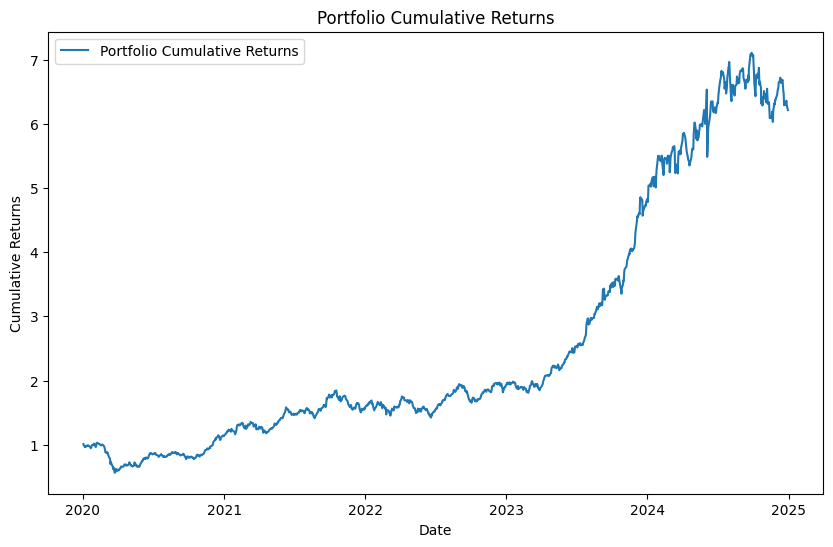

In [33]:
import yfinance as yf
import numpy as np
import pandas as pd

# Tickers and the final portfolio allocation
tickers = [
    'LT.NS', 'ADANIPOWER.NS', 'RECLTD.NS', 'PFC.NS',
    'GODREJPROP.NS', 'RELINFRA.NS' , 'BAJAJ-AUTO.NS', 'DLF.NS'
]

# Download historical data for the selected tickers
data = yf.download(tickers, start="2020-01-01", end="2024-12-31")['Close']

# Calculate daily returns for each stock
daily_returns = data.pct_change().dropna()

# Portfolio returns (weighted returns based on allocation)
weighted_returns = daily_returns.mul([allocations[ticker] / 1000000 for ticker in tickers], axis=1)

# Calculate portfolio returns
portfolio_returns = weighted_returns.sum(axis=1)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Calculate key metrics (e.g., Sharpe ratio, max drawdown, and total return)
total_return = cumulative_returns[-1] - 1  # Total return of the portfolio
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)  # Assuming 252 trading days in a year
max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()  # Maximum drawdown

# Output the results
print(f"Total Portfolio Return: {total_return * 100:.2f}%")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

# Plot the cumulative returns of the portfolio
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Portfolio Cumulative Returns')
plt.title('Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


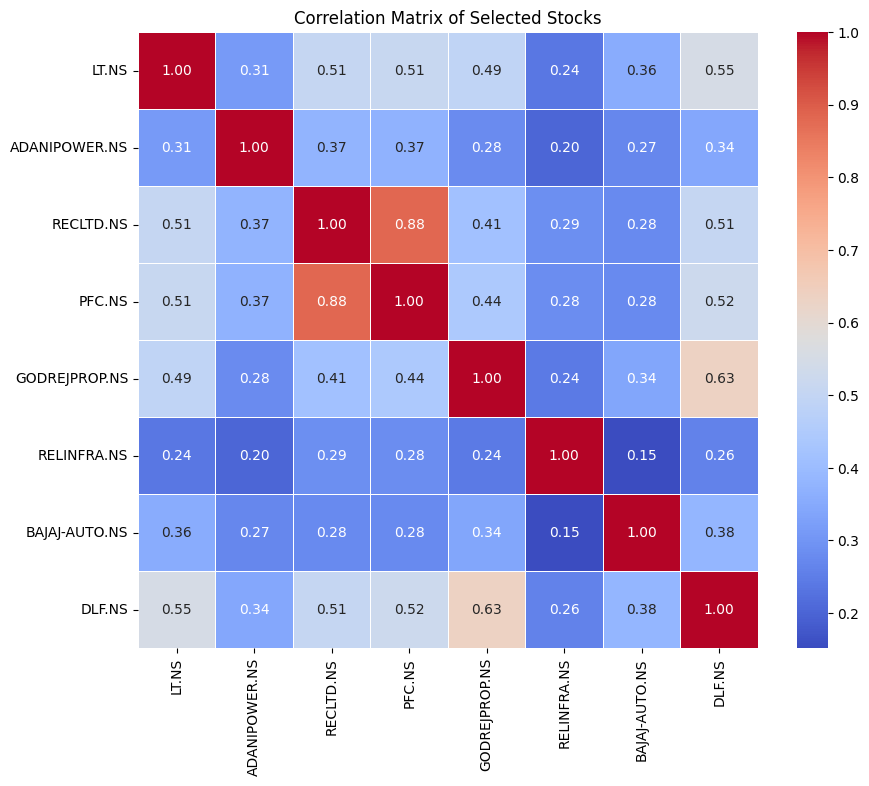

Final Diversified Portfolio Allocation (after removing highly correlated stocks):
ADANIPOWER.NS: ₹140731.36
PFC.NS: ₹124818.45
LT.NS: ₹41938.27
DLF.NS: ₹77530.18
RELINFRA.NS: ₹6684.24
GODREJPROP.NS: ₹92103.76
BAJAJ-AUTO.NS: ₹398280.91


In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Fetch data for selected stocks (historical data)
# Assuming we have 'df' DataFrame with stock price data for the selected stocks

selected_stocks = list(allocations.keys())
data = {}

# Assuming 'download_data' function retrieves the stock data for selected tickers
for ticker in selected_stocks:
    data[ticker] = forecast_summary[ticker]['df'][['ds', 'y']]

# Convert data to a unified DataFrame
df_combined = pd.DataFrame()

# Merge stock data into a single DataFrame with 'ds' as index
for ticker in selected_stocks:
    df_combined[ticker] = data[ticker].set_index('ds')['y']

# Step 2: Compute daily log returns for each stock
df_returns = np.log(df_combined / df_combined.shift(1))

# Step 3: Calculate the correlation matrix of returns
corr_matrix = df_returns.corr()

# Step 4: Visualize the correlation matrix (optional)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Selected Stocks")
plt.show()

# Step 5: Remove highly correlated stocks (e.g., remove any pair with correlation > 0.8)
threshold = 0.8
low_corr_stocks = set(selected_stocks)

# Iterate over the correlation matrix to check pairwise correlations
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            stock1 = corr_matrix.columns[i]
            stock2 = corr_matrix.columns[j]
            if stock1 in low_corr_stocks and stock2 in low_corr_stocks:
                low_corr_stocks.remove(stock2)  # Remove the second stock from the portfolio

# Step 6: Update allocation based on remaining stocks
filtered_allocations = {ticker: allocations[ticker] for ticker in low_corr_stocks}

# Step 7: Print the final diversified portfolio allocation
print("Final Diversified Portfolio Allocation (after removing highly correlated stocks):")
for ticker, amount in filtered_allocations.items():
    print(f"{ticker}: ₹{amount}")


In [28]:
# Step 6: Normalize the allocation to sum up to ₹1,000,000 after removing highly correlated stocks
total_allocated = sum(filtered_allocations.values())
desired_total = 1000000  # Total capital to allocate

# Normalize each stock allocation
normalized_allocations = {ticker: (amount / total_allocated) * desired_total
                          for ticker, amount in filtered_allocations.items()}

# Step 7: Print the final diversified and normalized portfolio allocation
print("Final Diversified and Normalized Portfolio Allocation (summing up to ₹1,000,000):")
for ticker, amount in normalized_allocations.items():
    print(f"{ticker}: ₹{amount:.2f}")


Final Diversified and Normalized Portfolio Allocation (summing up to ₹1,000,000):
ADANIPOWER.NS: ₹159543.60
PFC.NS: ₹141503.53
LT.NS: ₹47544.36
DLF.NS: ₹87894.01
RELINFRA.NS: ₹7577.75
GODREJPROP.NS: ₹104415.71
BAJAJ-AUTO.NS: ₹451521.03


In [31]:
# Function to rebalance the portfolio based on updated predictions
def rebalance_portfolio(forecast_summary, current_allocation, max_increase=0.1, min_decrease=0.05):
    # Initialize new allocation dictionary
    new_allocation = current_allocation.copy()

    # Loop through each stock and update the allocation based on its forecasted return
    for stock, data in forecast_summary.items():
        forecasted_return = (data['Prophet'] - data['latest_price']) / data['latest_price']
        current_weight = new_allocation.get(stock, 0)

        # Increase allocation for stocks with higher predicted returns
        if forecasted_return > 0:
            increase = current_weight * max_increase
            new_allocation[stock] = current_weight + increase

        # Decrease allocation for stocks with lower or negative predicted returns
        elif forecasted_return < 0:
            decrease = current_weight * min_decrease
            new_allocation[stock] = max(0, current_weight - decrease)

    # Normalize the allocation to sum to the total available capital
    total_allocation = sum(new_allocation.values())
    normalized_allocation = {stock: (weight / total_allocation) * 1000000 for stock, weight in new_allocation.items()}

    return normalized_allocation

# Example rebalance with current allocation and forecast summary
normalized_allocations = rebalance_portfolio(forecast_summary, normalized_allocations)

# Check the updated allocation
print("Rebalanced Portfolio Allocation:")
print(normalized_allocations)


Rebalanced Portfolio Allocation:
{'ADANIPOWER.NS': np.float64(159708.62877698918), 'PFC.NS': np.float64(141649.9030178433), 'LT.NS': np.float64(47593.539883215395), 'DLF.NS': np.float64(87984.92913472271), 'RELINFRA.NS': np.float64(6551.193865683896), 'GODREJPROP.NS': np.float64(104523.71962301014), 'BAJAJ-AUTO.NS': np.float64(451988.08569853543), 'RCOM.NS': np.float64(0.0), 'RECLTD.NS': np.float64(0.0), 'OFSS.NS': np.float64(0.0)}


In [35]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
import pandas as pd

def directional_accuracy(true, pred):
    return int(np.sign(pred - true) == np.sign(true - true))  # 1 if correct direction

def compare_models(forecast_summary):
    comparison_results = {}

    for stock, data in forecast_summary.items():
        true = data["latest_price"]
        preds = {
            "ARIMA": data["ARIMA"],
            "Prophet": data["Prophet"],
            "LSTM": data["LSTM"]
        }

        df = data['df']
        actual_last = df['y'].iloc[-1]
        actual_prev = df['y'].iloc[-2]

        model_metrics = {}
        ensemble_pred = np.mean(list(preds.values()))

        for model_name, pred in preds.items():
            rmse = np.sqrt(mean_squared_error([true], [pred]))
            mape = mean_absolute_percentage_error([true], [pred]) * 100
            dir_acc = int(np.sign(pred - actual_prev) == np.sign(actual_last - actual_prev))

            model_metrics[model_name] = {
                'Prediction': pred,
                'RMSE': rmse,
                'MAPE': mape,
                'Directional_Accuracy': dir_acc
            }

        # Add ensemble
        ensemble_rmse = np.sqrt(mean_squared_error([true], [ensemble_pred]))
        ensemble_mape = mean_absolute_percentage_error([true], [ensemble_pred]) * 100
        ensemble_dir = int(np.sign(ensemble_pred - actual_prev) == np.sign(actual_last - actual_prev))

        model_metrics['Ensemble'] = {
            'Prediction': ensemble_pred,
            'RMSE': ensemble_rmse,
            'MAPE': ensemble_mape,
            'Directional_Accuracy': ensemble_dir
        }

        comparison_results[stock] = model_metrics

    return comparison_results

# 🔍 Run comparison
model_comparison_results = compare_models(forecast_summary)

# 📊 Convert to DataFrame for tabular view
def to_dataframe(results):
    rows = []
    for stock, metrics in results.items():
        for model, values in metrics.items():
            rows.append({
                'Stock': stock,
                'Model': model,
                'Prediction': values['Prediction'],
                'RMSE': values['RMSE'],
                'MAPE': values['MAPE'],
                'Directional_Accuracy': values['Directional_Accuracy']
            })
    return pd.DataFrame(rows)

comparison_df = to_dataframe(model_comparison_results)
print(comparison_df)


            Stock     Model    Prediction         RMSE       MAPE  \
0           LT.NS     ARIMA   3654.130242    75.180290   2.100624   
1           LT.NS   Prophet   3793.086836   214.136885   5.983232   
2           LT.NS      LSTM   3721.423584   142.473633   3.980878   
3           LT.NS  Ensemble   3722.880220   143.930269   4.021578   
4         RCOM.NS     ARIMA      2.069041     0.089041   4.497010   
5         RCOM.NS   Prophet      2.086730     0.106730   5.390427   
6         RCOM.NS      LSTM      2.013501     0.033501   1.691977   
7         RCOM.NS  Ensemble      2.056424     0.076424   3.859805   
8   ADANIPOWER.NS     ARIMA    653.476884   114.026872  21.137616   
9   ADANIPOWER.NS   Prophet    735.627378   196.177365  36.366181   
10  ADANIPOWER.NS      LSTM    647.245605   107.795593  19.982499   
11  ADANIPOWER.NS  Ensemble    678.783289   139.333277  25.828765   
12      RECLTD.NS     ARIMA    542.110291    54.816651  11.249203   
13      RECLTD.NS   Prophet    608

In [36]:
comparison_df

,Stock,Model,Prediction,RMSE,MAPE,Directional_Accuracy
0,LT.NS,ARIMA,3654.130242,75.180290,2.100624,0
1,LT.NS,Prophet,3793.086836,214.136885,5.983232,0
2,LT.NS,LSTM,3721.423584,142.473633,3.980878,0
3,LT.NS,Ensemble,3722.880220,143.930269,4.021578,0
4,RCOM.NS,ARIMA,2.069041,0.089041,4.497010,1
5,RCOM.NS,Prophet,2.086730,0.106730,5.390427,1
6,RCOM.NS,LSTM,2.013501,0.033501,1.691977,1
7,RCOM.NS,Ensemble,2.056424,0.076424,3.859805,1
8,ADANIPOWER.NS,ARIMA,653.476884,114.026872,21.137616,1
9,ADANIPOWER.NS,Prophet,735.627378,196.177365,36.366181,1


from matplotlib import pyplot as plt
comparison_df['Prediction'].plot(kind='hist', bins=20, title='Prediction')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_df['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_df['MAPE'].plot(kind='hist', bins=20, title='MAPE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_df['Directional_Accuracy'].plot(kind='hist', bins=20, title='Directional_Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
comparison_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_df.plot(kind='scatter', x='Prediction', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_df.plot(kind='scatter', x='RMSE', y='MAPE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_df.plot(kind='scatter', x='MAPE', y='Directional_Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_df['Prediction'].plot(kind='line', figsize=(8, 4), title='Prediction')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
comparison_df['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
comparison_df['MAPE'].plot(kind='line', figsize=(8, 4), title='MAPE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
comparison_df['Directional_Accuracy'].plot(kind='line', figsize=(8, 4), title='Directional_Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison_df, x='Prediction', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison_df, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison_df, x='MAPE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison_df, x='Directional_Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)